Polygon points: [(509, 556), (521, 464)]
Polygon points: [(509, 556), (521, 464), (717, 471)]
Polygon points: [(509, 556), (521, 464), (717, 471), (732, 565)]
Saved polygon coordinates: [[509 556]
 [521 464]
 [717 471]
 [732 565]]


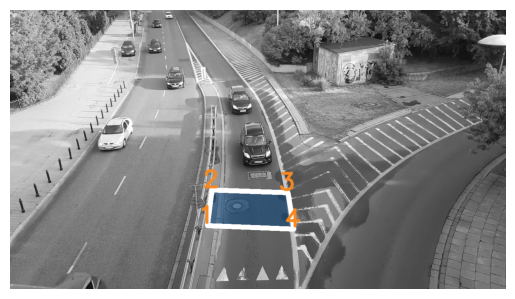

In [8]:
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

# Initialize the list to store points
clicked_points = []

# Mouse callback function to get the coordinates of the points
def mouse_callback(event, x, y, flags, param):
    global clicked_points, img_copy
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # Store the coordinates of the point clicked
        clicked_points.append((x, y))
        
        # Draw a circle at the point clicked
        cv2.circle(img_copy, (x, y), 5, (0, 0, 255), -1)  # Red circle
        cv2.putText(img_copy, f"({x},{y})", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        # Connect the points with a line (A -> B -> C -> D, etc.)
        if len(clicked_points) > 1:
            cv2.line(img_copy, clicked_points[-2], clicked_points[-1], (0, 255, 0), 2)  # Green line

        # Draw the final polygon after all points are clicked
        if len(clicked_points) > 1:
            cv2.line(img_copy, clicked_points[-1], clicked_points[0], (0, 255, 0), 2)  # Close the polygon
            print("Polygon points:", clicked_points)
            
            # Label the points
            color1 = sv.Color.from_hex("#004080")
            color2 = sv.Color.from_hex("#f78923")
            img_copy = sv.draw_filled_polygon(img_copy, np.array(clicked_points), color1, 0.5)
            img_copy = sv.draw_polygon(img_copy, np.array(clicked_points), sv.Color.WHITE, 12)
            
            # Label the points (if more than 4, dynamically label them as 1, 2, 3, ...)
            for i, point in enumerate(clicked_points):
                img_copy = sv.draw_text(
                    img_copy, str(i+1), sv.Point(point[0], point[1] - 30), color2, 2, 6
                )

# Load the video
video_path = './asset/videoplayback.mp4'  # Provide the correct path to your video
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Set the mouse callback to capture clicks
cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", mouse_callback)

# Loop to process video frames
while True:
    ret, frame = cap.read()
    
    if not ret:
        break  # Exit if the video ends
    
    img = frame.copy()

    # Convert to BGR to prepare for drawing and labeling
    img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

    img_copy = img.copy()
    
    # Show the frame
    cv2.imshow("Frame", img_copy)

    # Wait for the user to press a key
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Press 'q' to quit
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

# After exiting, save the points as a constant
POLYGON_COORDS = np.array(clicked_points)

# Now, use these saved coordinates for drawing and labeling
print("Saved polygon coordinates:", POLYGON_COORDS)

# Load a new frame/image (if needed)
cap = cv2.VideoCapture(video_path)
ret, img = cap.read()
cap.release()

# Convert the image to grayscale and then back to BGR
img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

# Set up colors
color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")

# Draw filled polygon and polygon border using saved coordinates
img = sv.draw_filled_polygon(img, POLYGON_COORDS, color1, 0.5)
img = sv.draw_polygon(img, POLYGON_COORDS, sv.Color.WHITE, 12)

# Add labels to the points from the saved coordinates
for i, point in enumerate(POLYGON_COORDS):
    img = sv.draw_text(
        img, str(i+1), sv.Point(point[0], point[1] - 30), color2, 2, 6
    )

# Show the final image with labels
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis for better presentation
plt.show()